<a href="https://colab.research.google.com/github/thayportellads/Jogo_pong_js/blob/main/tcc_script_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criando modelos de Machine Learning para detectar churn de clientes de Telecom

### [BASE](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset)
TCC DSA - Script do trabalho

### Descrição de Dados: 7.043 observações com 33 variáveis


In [1]:
!pip install scikit-plot -q
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.9 MB/s eta 0:00:00


In [2]:
# importar as bibliotecas necessárias
import pandas             as pd     # manipulação de dados
import numpy              as np     # manipulação de arrays
import matplotlib.pyplot  as plt    # visualização de dados
import seaborn            as sns    # visualização estatística dos dados
import scikitplot         as skplt  # visualização de dados e métricas de machine learning
import warnings                     # notificações
warnings.filterwarnings('ignore')   # configurar notificações para serem ignoradas

from sklearn.preprocessing    import LabelEncoder           # transformação de dados categóricos
from sklearn.model_selection  import train_test_split       # divisão em conjuntos de treino e teste
from sklearn.pipeline         import make_pipeline          # construção de fluxo de trabalho
from sklearn.model_selection  import cross_val_score        # avaliação de desempenho por cross-validation
from sklearn.preprocessing    import StandardScaler         # normalização dos dados
from imblearn.over_sampling import SMOTE, RandomOverSampler    # balanceamento dos dados
from sklearn.model_selection  import StratifiedKFold        # avaliação de desempenho com dados estratificados
from sklearn.model_selection import GridSearchCV            # criação de grade para avaliar hiperparâmetros
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay,roc_auc_score # avaliação de desempenho por f1, recall, matrix de confusão, AUC e acurácia

# modelos de classificação de dados
from sklearn.ensemble         import RandomForestClassifier
from sklearn.linear_model     import LogisticRegression
from xgboost                  import XGBClassifier
from catboost                 import CatBoostClassifier

In [ ]:
# importar os dados
dfo = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/Telco_customer_churn.xlsx')
dfo.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,86,5372,Moved


In [ ]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [ ]:
dfo.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [ ]:
## Padronizando o nome de colunas
dfo.columns = dfo.columns.str.replace(' ','_')
dfo.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip_Code',
       'Lat_Long', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Label', 'Churn_Score',
       'CLTV', 'Churn_Reason'],
      dtype='object')

In [ ]:
## Avaliando as colunas com mais 3 de váriaveis categoricas para realizar transformações necessárias
#  É possivel observar que existem váriaveis com opção de 3 ou 4 respostas, para essas variaveis vamos separar o conjunto por atributos e depois categorizar por sim ou não

# Criando as variaveis com atributos de entradas únicas:

val_unique = dfo[['Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Payment_Method']]

# Definir resultados para cada atributo, através da função
for i in val_unique:
  print(f'{dfo[i].unique()}')

['No' 'Yes' 'No phone service']
['DSL' 'Fiber optic' 'No']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [ ]:
## Removendo váriaveis que contem informações de respostas e que não serão bem vindas para treinar o modelo.

dfo.drop(['Churn_Score', 'CLTV', 'Churn_Reason'],axis=1, inplace = True)

In [ ]:
## Removendo váriaveis que contem informações irrelevantes, como ID do cliente, Contagem e Pais e Estados por serem dados únicos.
dfo.drop(['Count', 'State', 'Country', 'CustomerID','Lat_Long'], axis=1, inplace =True)

In [ ]:
dfo['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [ ]:
# Organizar as cidades removendo espaços em branco, padronizando o dado
dfo['City'].replace(' ','_',regex= True, inplace =True)
dfo['City'].unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

In [ ]:
# Avaliando a coluna Total Charges e transformando valores faltantes em zero
dfo.loc[(dfo['Total_Charges'] == " "), 'Total_Charges']=0
print(len(dfo.loc[dfo['Total_Charges'] == " "]))

0


In [ ]:
# Transformando a coluna Total Charges em valores númericos float
dfo['Total_Charges'] = pd.to_numeric(dfo['Total_Charges'], errors='coerce')
dfo.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Label           object
dtype: object

Churn_Label
No     5174
Yes    1869
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

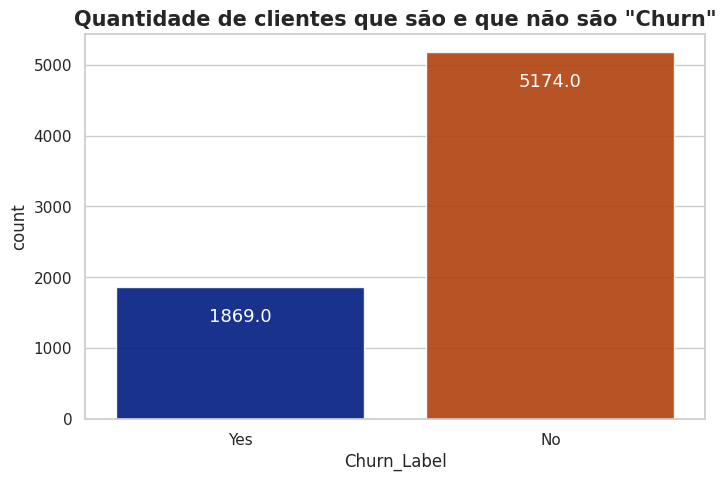

In [ ]:
## Plotar gráfico
# Contar a frequência de categorias em uma coluna categórica
display(dfo['Churn_Label'].value_counts())

plt.figure(facecolor='White')
sns.set(style='whitegrid')
plt.figure(figsize=(8,5), facecolor='White')
ax=sns.countplot(data=dfo, x='Churn_Label', saturation=1, alpha=0.9, palette='dark')
ax.set_title('Quantidade de clientes que são e que não são "Churn"', fontsize=15, fontweight='bold')

for p in ax.patches:
  ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=13)

In [ ]:
dfo.describe()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,93521.964646,36.282441,-119.798880,32.371149,64.761692,2279.734304
std,1865.794555,2.455723,2.157889,24.559481,30.090047,2266.794470
min,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,92102.000000,34.030915,-121.815412,9.000000,35.500000,398.550000
50%,93552.000000,36.391777,-119.730885,29.000000,70.350000,1394.550000
75%,95351.000000,38.224869,-118.043237,55.000000,89.850000,3786.600000
max,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000


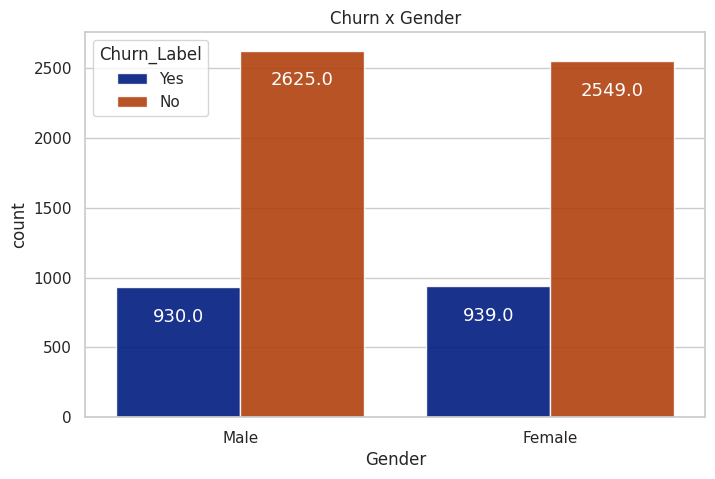

In [ ]:
# Checando relação de Gender com o Churn
plt.figure(figsize=(8,5), facecolor='white')
sns.set(style='whitegrid')
ax = sns.countplot(data=dfo, x='Gender', hue='Churn_Label', saturation=1, alpha=0.9, palette='dark')
ax.set_title('Churn x Gender')
for p in ax.patches:
  ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=13)
plt.show()

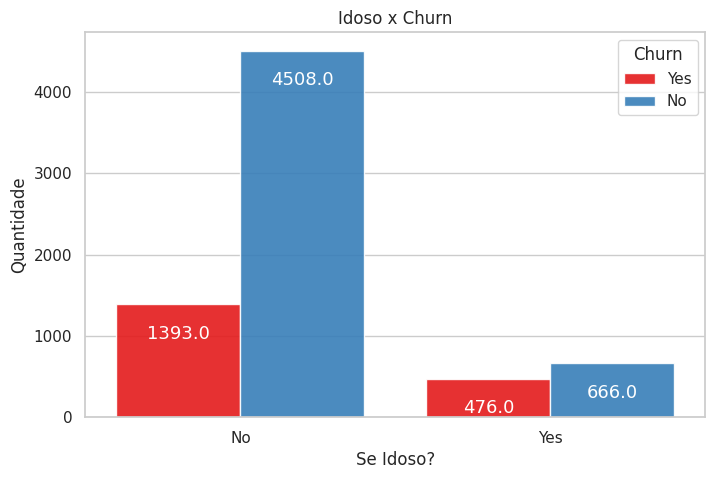

In [ ]:
# Checando a variavel Senior Citizen
plt.figure(figsize=(8,5), facecolor='white')
sns.set(style='whitegrid')
ax = sns.countplot(data=dfo, x='Senior_Citizen', hue='Churn_Label', saturation=1, alpha=0.9, palette='Set1')
ax.set_title('Idoso x Churn')
plt.xlabel('Se Idoso?')
plt.ylabel('Quantidade')
for p in ax.patches:
  ax.legend(title='Churn')
  ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=13)
plt.show()

<Figure size 1200x500 with 0 Axes>

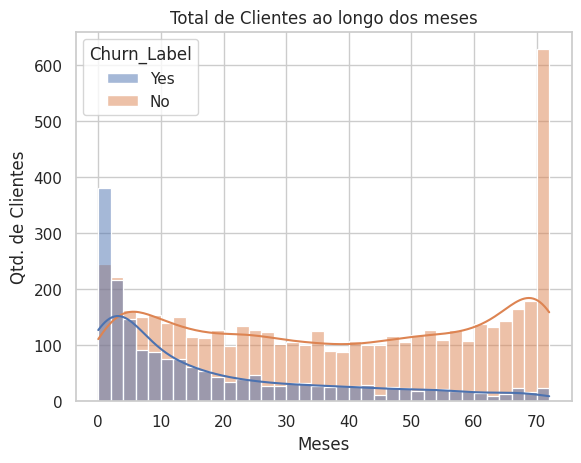

In [ ]:
# Checando a variável tempo como Cliente
plt.figure(figsize=(12,5), facecolor='white')
plt.figure(facecolor='white')
sns.set(style='whitegrid')
sns.histplot(data=dfo, x='Tenure_Months', hue='Churn_Label', binwidth=2, kde=True)
plt.title('Total de Clientes ao longo dos meses')
plt.xlabel('Meses')
plt.ylabel('Qtd. de Clientes')
plt.show()

<Figure size 1300x500 with 0 Axes>

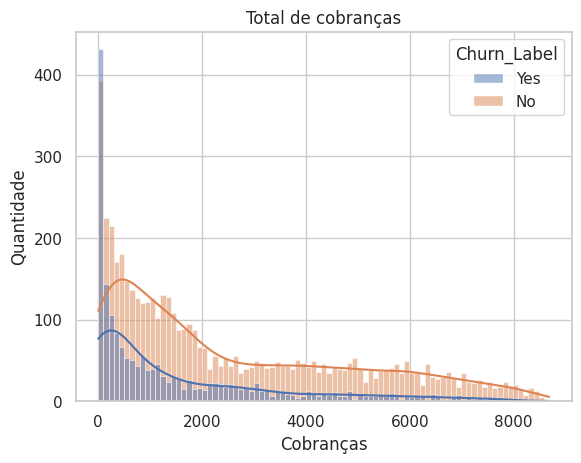

In [ ]:
# Checando a variável Cobrança total
plt.figure(figsize=(13,5), facecolor='white')
plt.figure(facecolor='white')
sns.set(style='whitegrid')
sns.histplot(data=dfo, x='Total_Charges', hue='Churn_Label', binwidth=100, kde=True)
plt.title('Total de cobranças')
plt.xlabel('Cobranças')
plt.ylabel('Quantidade')
plt.show()

# Criando uma nova base a partir do Data frame dfo para ajustar as variáveis e balancear as classes

In [ ]:
#Verificando variaveis e atributos
df1 = dfo.copy()
df1.nunique()

City                 1129
Zip_Code             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior_Citizen          2
Partner                 2
Dependents              2
Tenure_Months          73
Phone_Service           2
Multiple_Lines          3
Internet_Service        3
Online_Security         3
Online_Backup           3
Device_Protection       3
Tech_Support            3
Streaming_TV            3
Streaming_Movies        3
Contract                3
Paperless_Billing       2
Payment_Method          4
Monthly_Charges      1585
Total_Charges        6531
Churn_Label             2
dtype: int64

In [ ]:
# identificar as variáveis com 2 labels
var_2 = df1.nunique()[df1.nunique() == 2].keys().tolist()
# checando as variaveis com 2 atributos
df1[var_2].head()



,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Paperless_Billing,Churn_Label
0,Male,No,No,No,Yes,Yes,Yes
1,Female,No,No,Yes,Yes,Yes,Yes
2,Female,No,No,Yes,Yes,Yes,Yes
3,Female,No,Yes,Yes,Yes,Yes,Yes
4,Male,No,No,Yes,Yes,Yes,Yes


In [ ]:
# distinguir os atributos categóricos dos numéricos e identificar os atributos numéricos
result = [col for col in df1.select_dtypes(['int', 'float']).columns.tolist() if col not in var_2]
print(result)

['Zip_Code', 'Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Total_Charges']


In [ ]:
## identificar atributos categóricos sendo: não numéricos e nem categóricos que foram tratados na etapa anterior
cat_resul = [col for col in df1.columns.tolist() if col not in var_2 + result]

# checar as variáveis categóricas
df1[cat_resul].head()

,City,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Payment_Method
0,Los_Angeles,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check
1,Los_Angeles,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check
2,Los_Angeles,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Electronic check
3,Los_Angeles,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Electronic check
4,Los_Angeles,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Bank transfer (automatic)


In [ ]:
# aplicar variáveis dummy
df1 = pd.get_dummies(df1, columns=cat_resul)
df1.head()

,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Paperless_Billing,...,Streaming_Movies_No,Streaming_Movies_No internet service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,Yes,...,True,False,False,True,False,False,False,False,False,True
1,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,Yes,...,True,False,False,True,False,False,False,False,True,False
2,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,...,False,False,True,True,False,False,False,False,True,False
3,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,...,False,False,True,True,False,False,False,False,True,False
4,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,...,False,False,True,True,False,False,True,False,False,False


In [ ]:
# instanciando LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# aplicar o Label Encoding
for i in var_2:
    df1[i] = label.fit_transform(df1[i])

# checar alterações no data frame
df1.head()

,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Paperless_Billing,...,Streaming_Movies_No,Streaming_Movies_No internet service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,90003,33.964131,-118.272783,1,0,0,0,2,1,1,...,True,False,False,True,False,False,False,False,False,True
1,90005,34.059281,-118.307420,0,0,0,1,2,1,1,...,True,False,False,True,False,False,False,False,True,False
2,90006,34.048013,-118.293953,0,0,0,1,8,1,1,...,False,False,True,True,False,False,False,False,True,False
3,90010,34.062125,-118.315709,0,0,1,1,28,1,1,...,False,False,True,True,False,False,False,False,True,False
4,90015,34.039224,-118.266293,1,0,0,1,49,1,1,...,False,False,True,True,False,False,True,False,False,False


In [ ]:
df1.shape

(7043, 1173)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 1173 entries, Zip_Code to Payment_Method_Mailed check
dtypes: bool(1160), float64(4), int64(9)
memory usage: 8.5 MB


In [ ]:
df1['Churn_Label']

0       1
1       1
2       1
3       1
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: Churn_Label, Length: 7043, dtype: int64

In [ ]:
# embaralhar os dados
df_blc = df1.reindex(np.random.permutation(df1.index))

# separar a classe-alvo das classes independentes
# Separando X e y
X = df_blc.drop('Churn_Label', axis=1)
y = df_blc['Churn_Label']

# verificar tamanho das variáveis
print(f'As variáveis independentes estão em X: {X.shape[0]} registros, { X.shape[1]} atributos')
print(f'A variável alvo "Churn" está em y: {y.shape[0]} registros.')

As variáveis independentes estão em X: 7043 registros, 1172 atributos
A variável alvo "Churn" está em y: 7043 registros.


In [ ]:
# Separando a base de treino e tese

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, shuffle=True, random_state=42)

# Verificando tamanho dos conjuntos
print(f'O conjunto de treino tem {X_train.shape[0]} registros.')
print(f'O conjunto de testes tem {X_test.shape[0]} registros.')

O conjunto de treino tem 4930 registros.
O conjunto de testes tem 2113 registros.


In [ ]:
def model(X, y, clf, quite=False):

    # converter variáveis em arrays
    X = np.array(X)
    y = np.array(y)

    # Criando o fluxo de trabalho
    ## 1. Padronizar os dados com o StandardScaler
    ## 2. classificar os dados
    pipeline = make_pipeline(StandardScaler(), clf)

    # avaliação do modelo por validação cruzada de acordo com o valor de Recall
    scores = cross_val_score(pipeline, X, y, scoring='recall')
    # mostrar média do valor de Recall e desvio padrão do modelo
    if quite == False:
        print(f"Recall: {scores.mean():.2f} (+/- {scores.std():.2f})")
    # retornar a média dos valores de Recall obtidos na validação cruzada
    return scores.mean()

In [ ]:
# RandomForest BASE
rf = RandomForestClassifier(random_state=42)
# Avaliar desempenho do modelo com a função
score_rf = model(X_train, y_train, rf)

Recall: 0.49 (+/- 0.04)


In [ ]:
# instanciar modelo de padronização
scaler = StandardScaler().fit(X_train)

# aplicar padronização nos dados de treino
X_train = scaler.transform(X_train)

# instanciar modelo de SMOTE
smote = SMOTE(random_state=42)

# aplicar smote nos dados de treino
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train, y_train)

# verificar o balanceamento das classes
print(pd.Series(y_train_res_smote).value_counts())

Churn_Label
0    3622
1    3622
Name: count, dtype: int64


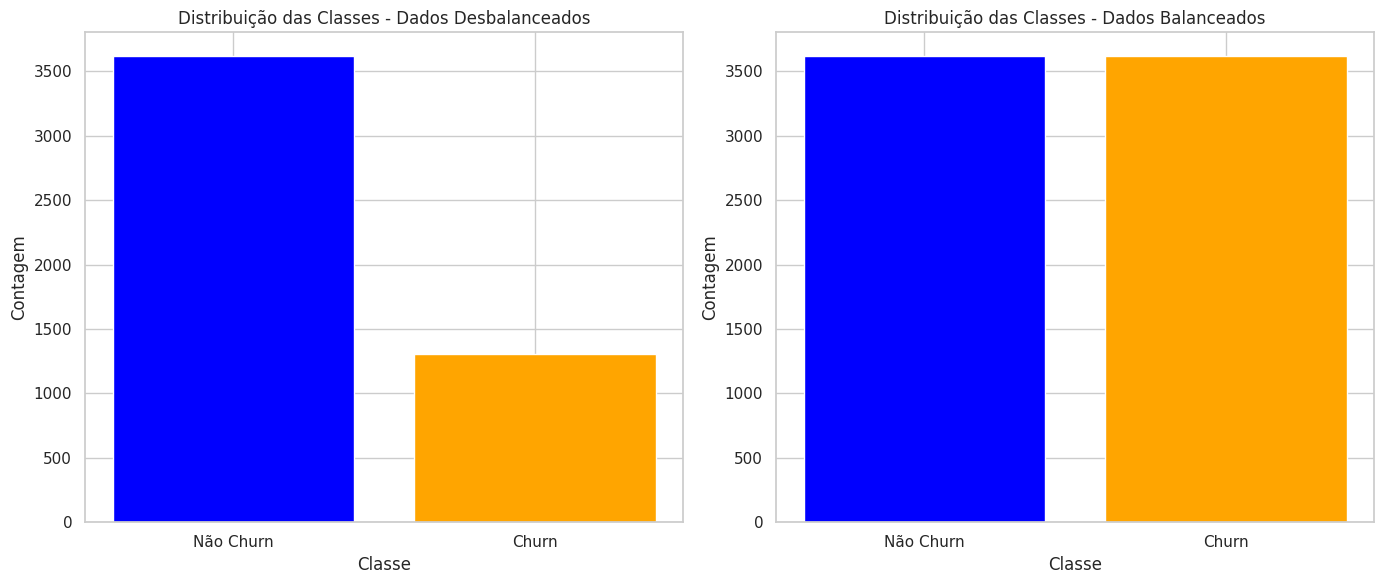

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Instanciar modelo de padronização
scaler = StandardScaler().fit(X_train)

# Aplicar padronização nos dados de treino
X_train_scaled = scaler.transform(X_train)

# Instanciar modelo de SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE nos dados de treino
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_scaled, y_train)

# Verificar o balanceamento das classes antes e depois do SMOTE
original_counts = pd.Series(y_train).value_counts()
resampled_counts = pd.Series(y_train_res_smote).value_counts()

# Criar subplots para os gráficos de barras
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de barras para o conjunto de dados original
ax[0].bar(original_counts.index, original_counts.values, color=['blue', 'orange'])
ax[0].set_title('Distribuição das Classes - Dados Desbalanceados')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Contagem')
ax[0].set_xticks(original_counts.index)
ax[0].set_xticklabels(['Não Churn', 'Churn'])

# Gráfico de barras para o conjunto de dados após SMOTE
ax[1].bar(resampled_counts.index, resampled_counts.values, color=['blue', 'orange'])
ax[1].set_title('Distribuição das Classes - Dados Balanceados')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Contagem')
ax[1].set_xticks(resampled_counts.index)
ax[1].set_xticklabels(['Não Churn', 'Churn'])

# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:
# instanciar os modelos
rf   = RandomForestClassifier()
lr   = LogisticRegression()
xgb  = XGBClassifier()

# criar listas para armazenar:
## o modelo do classificador
model_class = []
## o valor do Recall:
recall = []
# criar loop para percorrer os modelos de classificação
for clf in (rf, lr, xgb):

    # identificar o classificador
    model_class.append(clf.__class__.__name__)

    # aplicar função 'model' e armazenar o valor de Recall obtido
    recall.append(model(X_train_res_smote, y_train_res_smote, clf))
# salvar o resultado de Recall obtido em cada modelo de classificação em uma variável
results = pd.DataFrame(data=recall, index=model_class, columns=['Recall'])

# mostrar os modelos com base no valor de Recall obtido, do maior para o menor
results.sort_values(by='Recall', ascending=False)

Recall: 0.81 (+/- 0.23)
Recall: 0.85 (+/- 0.10)
Recall: 0.80 (+/- 0.25)


,Recall
LogisticRegression,0.845620
RandomForestClassifier,0.811603
XGBClassifier,0.804144


In [ ]:
# instanciar o modelo XGBoost
xgb = XGBClassifier(learning_rate=0.1, random_state=42) ## definir a taxa de aprendizado em 0.1

# definir dicionário para descobrir a quantidade ideal de árvores em um range de 0 a 100 com incremento de 50
param_grid = {'n_estimators':range(0,100,10),
              'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'gamma': range(0,1,1)}

# configurar validação cruzada com 10 dobras estratificadas
## shuffle=True para embaralhar os dados antes de dividir
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# configuração da busca de combinações cruzadas com o classificador XGBoost
grid_search_xgb = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)

# realizar a busca do melhor parâmetro para 'n_estimators'
grid_result= grid_search_xgb.fit(X_train_res_smote, y_train_res_smote)

# imprimir o melhor parâmetro encontrado para 'n_estimators'
print(f"Melhor: {grid_result.best_score_:.4f} para {grid_result.best_params_}.")

Melhor: 0.8824 para {'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10}.


In [ ]:
# instanciar o modelo final do XGBoost com os melhores hiperparâmetros encontrados
xgb = XGBClassifier(learning_rate=0.1 , n_estimators=10, max_depth=3, min_child_weight=3, gamma=0)

# treinar o modelo com dados de treino
xgb.fit(X_train_res_smote, y_train_res_smote)

# padronizar os dados de teste
X_test = scaler.transform(X_test)

# fazer previsões com os dados de teste
y_pred_xbg = xgb.predict(X_test)

ROC AUC Score on testing: 0.76
ROC AUC Score on training: 0.77
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1552
           1       0.55      0.73      0.63       561

    accuracy                           0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113



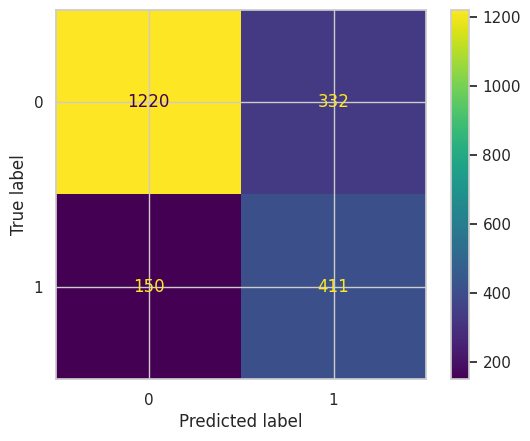

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

test_roc_auc = roc_auc_score(y_test, y_pred_xbg)
train_roc_auc = roc_auc_score(y_train,xgb.predict(X_train))
print(f"ROC AUC Score on testing: {test_roc_auc:.2f}" )
print(f"ROC AUC Score on training: {train_roc_auc:.2f}" )
print(classification_report(y_test, y_pred_xbg))

Testando RandomForest Metodo de avaliar melhores parametros

In [ ]:
# instanciar o modelo RandomForest
rf = RandomForestClassifier(random_state=42) ## definir a taxa de aprendizado em 0.1

# definir dicionário para descobrir a quantidade ideal de árvores em um range de 0 a 100 com incremento de 50
param_grid = {'n_estimators':range(0,100,10),
              'max_depth':range(1,10,2),
              'min_samples_leaf':range(1,4,2)}

# configurar validação cruzada com 10 dobras estratificadas
## shuffle=True para embaralhar os dados antes de dividir
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# configuração da busca de combinações cruzadas com o classificador XGBoost
grid_search_rf = GridSearchCV(rf, param_grid, scoring="recall", n_jobs=-1, cv=kfold)

# realizar a busca do melhor parâmetro para 'n_estimators'
grid_result= grid_search_rf.fit(X_train_res_smote, y_train_res_smote)

# imprimir o melhor parâmetro encontrado para 'n_estimators'
print(f"Melhor: {grid_result.best_score_:.4f} para {grid_result.best_params_}.")

Melhor: 0.8766 para {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}.


In [ ]:
# instanciar o modelo final do  RandomForest com os melhores hiperparâmetros encontrados
rf = RandomForestClassifier(random_state=42, n_estimators=60, max_depth=1, min_samples_leaf=1)

# treinar o modelo com dados de treino
rf.fit(X_train_res_smote, y_train_res_smote)

# padronizar os dados de teste
X_test = scaler.transform(X_test)

# fazer previsões com os dados de teste
y_pred_rf = rf.predict(X_test)

ROC AUC Score on testing: 0.75
ROC AUC Score on training: 0.75
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1552
           1       0.47      0.86      0.61       561

    accuracy                           0.70      2113
   macro avg       0.70      0.75      0.68      2113
weighted avg       0.80      0.70      0.72      2113



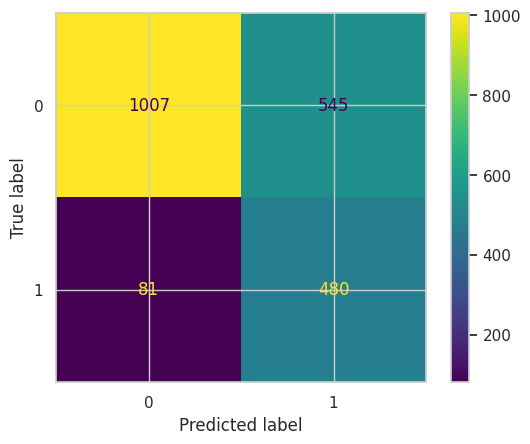

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

test_roc_auc = roc_auc_score(y_test, y_pred_rf)
train_roc_auc = roc_auc_score(y_train, rf.predict(X_train))
print(f"ROC AUC Score on testing: {test_roc_auc:.2f}" )
print(f"ROC AUC Score on training: {train_roc_auc:.2f}" )
print(classification_report(y_test, y_pred_rf))

In [ ]:
# instanciar o modelo LogitRegression
lr = LogisticRegression(random_state=42, max_iter=100)

# definir dicionário para descobrir a quantidade ideal de árvores em um range de 0 a 100 com incremento de 50
param_grid = {'C':[0.01,0.1,1.0,10,100]}


# configurar validação cruzada com 10 dobras estratificadas
## shuffle=True para embaralhar os dados antes de dividir
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# configuração da busca de combinações cruzadas com o classificador XGBoost
grid_search_lg = GridSearchCV(lr, param_grid, scoring="recall", n_jobs=-1, cv=kfold)

# realizar a busca do melhor parâmetro para 'n_estimators'
grid_result= grid_search_lg.fit(X_train_res_smote, y_train_res_smote)

# imprimir o melhor parâmetro encontrado para 'n_estimators'
print(f"Melhor: {grid_result.best_score_:.4f} para {grid_result.best_params_}.")

In [ ]:
# instanciar o modelo final do  RandomForest com os melhores hiperparâmetros encontrados
lr =  LogisticRegression(random_state=42, max_iter=100, C=0.01)

# treinar o modelo com dados de treino
lr.fit(X_train_res_smote, y_train_res_smote)

# padronizar os dados de teste
X_test = scaler.transform(X_test)

# fazer previsões com os dados de teste
y_pred_lr = lr.predict(X_test)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

test_roc_auc = roc_auc_score(y_test, y_pred_lr)
train_roc_auc = roc_auc_score(y_train, lr.predict(X_train))
print(f"ROC AUC Score on testing: {test_roc_auc:.2f}" )
print(f"ROC AUC Score on training: {train_roc_auc:.2f}" )
print(classification_report(y_test, y_pred_lr))

In [ ]:
from sklearn.metrics import roc_curve , auc

fpr_xgb, tpr_xgb, threshold = roc_curve(y_test, y_pred_xbg)
fpr_rf, tpr_rf,theshold = roc_curve(y_test,y_pred_rf)
fpr_lr, tpr_lr, threshold = roc_curve(y_test, y_pred_lr)

In [ ]:
# Plot ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, color="red", lw=2, label='ROC curve XGB (area={:.2f})'.format(auc(fpr_xgb, tpr_xgb)))
plt.plot(fpr_rf, tpr_rf, color="navy", lw=2, label='ROC curve RF(area={:.2f})'.format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_lr, tpr_lr, color="green", lw=2, label='ROC curve LG (area={:.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charastiric ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score, accuracy_score, f1_score
precisionI=[]
recallI=[]
accuracyI=[]
F1_scoreI=[]
for i in [y_pred_xbg, y_pred_rf, y_pred_lr]:
     precision=precision_score(y_test, i )
     recall = recall_score(y_test, i )
     accuracy = accuracy_score(y_test, i)
     F1_score = f1_score(y_test, i)
     precisionI.append((round(precision,2)))
     recallI.append(round(recall,2))
     accuracyI.append(round(accuracy,2))
     F1_scoreI.append(round(F1_score,2))

In [ ]:
dt={
    'Precision':precisionI,
    'Recall': recallI,
    'Accuracy' : accuracyI,
    'F1_score': F1_scoreI
}
index = ["XGBoost",'Random Forest', 'Regressão Logistica']

In [ ]:
dt_result = pd.DataFrame(dt, index)
dt

In [ ]:
# Instanciando a matrix de confusão
from sklearn.metrics import confusion_matrix

#criando o figure e o axes no matplotlib
fig, ax = plt.subplots(figsize=(12,8),ncols=2,nrows=2)

#primeiro gráfico -> Regressão Logística Dados balanceados
plot_confusion_matrix(grid_search_lr,x_test,y_test,normalize='true',ax=ax[0][0],cmap='Blues');
ax[0][0].set_title('Dados Balanceados - Regressão Logística',loc='center',pad=10,fontdict={'fontsize':15},color='blue')

#segundo gráfico -> XGBoost Dados balanceados
plot_confusion_matrix(grid_search_xgb,x_test,y_test,normalize='true',ax=ax[0][1],cmap='Blues');
ax[0][1].set_title('Dados Balanceados - XGBoost',loc='center',pad=10,fontdict={'fontsize':15},color='blue')


#plotando o gráfico
plt.tight_layout(pad=4.0);